In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sionna
import scipy

In [14]:
#fc = 8 GHz
#BW = 20 MHz
#lambda/2 antenna spacing
#channel model: ray tracing
#antenna configuration: UPA
#Tx and Rx 50-element antenna array (10 x 5 UPA)

FC = 8e9
BW = 20e6
D_BY_LAMBDA = 0.5
N_TX = 50
N_RX = 50
N_ROWS = 10
N_COLS = 5
TX_LOC = [41,4,19]
RX_LOC = [-291,-12,15]
PI = np.pi

def find_thresh(arr, N):

    if N <= 0:
        return np.max(arr) + 1
    if N >= arr.size:
        return np.min(arr)
    
    sorted_arr = np.sort(arr)[::-1]
    threshold = sorted_arr[N-1]
    
    return threshold

In [3]:
scene = sionna.rt.load_scene(sionna.rt.scene.etoile)
scene.frequency = FC

In [4]:
scene.tx_array = sionna.rt.PlanarArray(num_rows=N_ROWS,
                             num_cols=N_COLS,
                             vertical_spacing=D_BY_LAMBDA,
                             horizontal_spacing=D_BY_LAMBDA,
                             pattern="tr38901",
                             polarization="V")

scene.rx_array = sionna.rt.PlanarArray(num_rows=N_ROWS,
                             num_cols=N_COLS,
                             vertical_spacing=D_BY_LAMBDA,
                             horizontal_spacing=D_BY_LAMBDA,
                             pattern="tr38901",
                             polarization="V")

tx = sionna.rt.Transmitter(name="tx",
                 position=TX_LOC,
                 display_radius=2)

scene.add(tx)

rx = sionna.rt.Receiver(name="rx",
              position=RX_LOC,
              display_radius=2)

scene.add(rx)

tx.look_at(rx)

In [5]:
p_solver  = sionna.rt.PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=7,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=True,
                 seed=41)

# scene.preview(paths=paths, clip_at=20)

Shape of h_freq:  (1, 50, 1, 50, 1, 1000)


Text(0.5, 1.0, 'Channel frequency response')

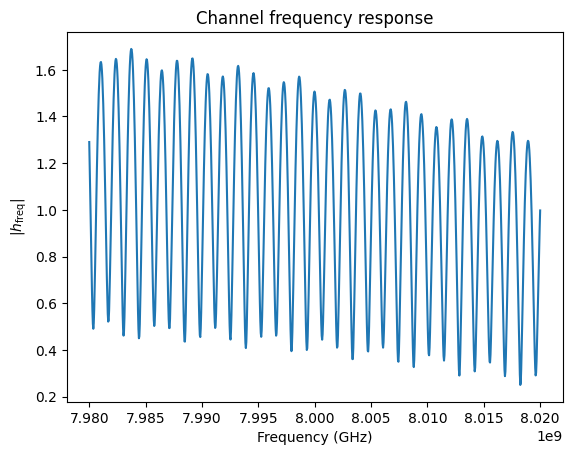

In [6]:
nfreqs = 1000
sweep_freqs = np.linspace(FC-BW, FC+BW, num=nfreqs)
h_freq_sweep = paths.cfr(frequencies=sweep_freqs,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
print("Shape of h_freq: ", h_freq_sweep.shape)
plt.figure()
plt.plot(sweep_freqs, np.abs(h_freq_sweep)[0,0,0,0,0,:])
plt.xlabel("Frequency (GHz)")
plt.ylabel(r"|$h_\text{freq}$|")
plt.title("Channel frequency response")

Shape of h_freq_FC:  (1, 50, 1, 50, 1, 1)
1.4914613


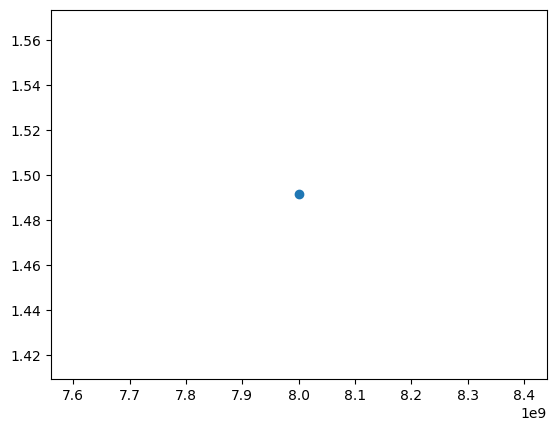

In [7]:
h_freq_FC = paths.cfr(frequencies=FC,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
print("Shape of h_freq_FC: ", h_freq_FC.shape)
print(np.abs(h_freq_FC)[0,0,0,0,0,0])
plt.scatter(8e9, np.abs(h_freq_FC)[0,0,0,0,0,:])

In [8]:
h_freq = h_freq_FC.reshape(50,50)
h_freq
U, S, Vh = np.linalg.svd(h_freq)

In [9]:
a, tau = paths.cir(normalize_delays=True, out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
print("Shape of a: ", a.shape)

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
print("Shape of tau: ", tau.shape)

t = tau[0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,:,0]
a_max = np.max(a_abs)

# # And plot the CIR
# plt.figure()
# plt.title("Channel impulse response")
# plt.stem(t, a_abs)
# plt.xlabel(r"$\tau$ [ns]")
# plt.ylabel(r"$|a|$")

Shape of a:  (1, 50, 1, 50, 10, 1)
Shape of tau:  (1, 1, 10)


In [12]:
N_PATHS = tau.shape[2]
threshold = find_thresh(S, N_PATHS)
print("threshold: ", threshold)
S_thresh = S[S >= threshold]
rank_h = np.linalg.matrix_rank(h_freq)
rank_h
print(S)
print("numpy rank_h: ", rank_h)
print("my rank_h: ", S_thresh.size)
cond_num = np.linalg.cond(h_freq)
print("condition number: ", cond_num)

threshold:  2.1788117e-06
[4.17656136e+01 2.54647770e+01 1.02007494e+01 1.58884358e+00
 7.16814399e-01 2.90739119e-01 2.37335861e-02 3.14183388e-04
 1.17342846e-04 2.17881166e-06 2.07003131e-06 1.99570513e-06
 1.81274049e-06 1.66625853e-06 1.45036358e-06 1.27523708e-06
 1.19544029e-06 1.16137562e-06 1.05444485e-06 1.00746263e-06
 9.85914767e-07 9.19589183e-07 8.75598289e-07 8.55208725e-07
 7.96163135e-07 7.73993975e-07 7.52780238e-07 7.09418714e-07
 6.58951762e-07 6.17003650e-07 5.51396511e-07 5.40352062e-07
 4.92474214e-07 4.69697341e-07 4.42405423e-07 4.10050006e-07
 3.89538911e-07 3.65512165e-07 3.37681968e-07 2.75199028e-07
 2.65030678e-07 2.34639401e-07 2.11835342e-07 1.97130674e-07
 1.58255915e-07 1.35331348e-07 9.42039478e-08 5.50649517e-08
 4.06491658e-08 1.89541041e-08]
numpy rank_h:  8
my rank_h:  10
condition number:  2203512800.0


In [37]:
def create_e(n, delta, omega):
    e = np.empty((n,), dtype = np.complex64)
    for i in range(n):
        e[i] = np.exp(-1j*2*PI*delta*omega)
    return e * 1 / np.sqrt(n)

def create_U_P2P(n, delta,):
    U = []
    for i in range(n):
        U.append(create_e(n, delta, i / (n * delta)))
    return np.array(U)

In [43]:
Ut = create_U_P2P(N_TX, D_BY_LAMBDA)
Ur = create_U_P2P(N_RX, D_BY_LAMBDA)
Ut.shape

(50, 50)